In [1]:
!git clone https://github.com/sanepunk/ViT.git

Cloning into 'ViT'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 58 (delta 23), reused 38 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (58/58), 443.30 KiB | 23.33 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from ViT.models import ViT
import sys
import numpy as np
from sklearn.metrics import accuracy_score
torch.set_num_threads(4)
torch.cuda.empty_cache()

In [3]:
model = ViT(
    image_size=32,
    in_channels=3,
    patch_size=4,
    num_transformer_layers=20,
    embedding_dim=64,
    mlp_size=128,
    num_heads=4,
    attention_dropout=0.1,
    mlp_dropout=0.2,
    embedding_dropout=0.1,
    num_classes=10
)
# try:
#     model.load_state_dict(torch.load('model_interrupted.pth'))
# except:
#     print("Model not available")
model = model.to('cuda')
train_accs = []
test_accs = []
train_losses = []
test_losses = []
def handle_interrupt():
    print("\nTraining interrupted by user (Ctrl+C). Performing cleanup...")
    torch.save(model.state_dict(), "model_interrupted.pth")
    np.savez('training_results.npz', train_accs, test_accs, train_losses, test_losses)
    print("Model state saved.")
    sys.exit(0)

In [12]:
train_accs = []
test_accs = []
train_losses = []
test_losses = []

In [5]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
trainset = torchvision.datasets.CIFAR10(root='./data', train = True, download = True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=16, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

100%|██████████| 170M/170M [00:13<00:00, 12.7MB/s]


In [ ]:
try:
    no_improve_count = 0
    prev_train_loss = float('inf')
    for epoch in range(10):
        model.train()
        running_loss = 0.0
        all_train_labels = []
        all_train_preds = []
        train_bar = tqdm(trainloader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training', ncols=100)

        for batch_idx, (inputs, labels) in enumerate(train_bar):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()


            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(predicted.cpu().numpy())

            running_loss += loss.item()
            train_accuracy = accuracy_score(all_train_labels, all_train_preds) * 100
            train_bar.set_postfix(loss=running_loss / (batch_idx + 1), acc=train_accuracy)
        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_acc = accuracy_score(all_train_labels, all_train_preds) * 100
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        if epoch_train_loss < prev_train_loss:
            prev_train_loss = epoch_train_loss
            no_improve_count = 0
        else:
            no_improve_count += 1

        if no_improve_count > 5:
            print(f"Training stopped early at epoch {epoch + 1} due to no improvement in training loss.")
            break

        model.eval()
        all_test_labels = []
        all_test_preds = []
        running_test_loss = 0.0

        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to('cuda'), labels.to('cuda')
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                all_test_labels.extend(labels.cpu().numpy())
                all_test_preds.extend(predicted.cpu().numpy())

        epoch_test_loss = running_test_loss / len(testloader)
        epoch_test_acc = accuracy_score(all_test_labels, all_test_preds) * 100
        test_losses.append(epoch_test_loss)
        test_accs.append(epoch_test_acc)

        print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {epoch_train_loss:.4f} - Train Accuracy: {epoch_train_acc:.2f}%')
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Test Loss: {epoch_test_loss:.4f} - Test Accuracy: {epoch_test_acc:.2f}%')

    print("\nTraining completed!")
    print(f"Final Training Accuracy: {train_accs[-1]:.2f}%")
    print(f"Final Test Accuracy: {test_accs[-1]:.2f}%")


except KeyboardInterrupt:
    handle_interrupt()

Epoch 1/10 - Training: 100%|█████████████████| 391/391 [00:44<00:00,  8.84it/s, acc=35.3, loss=1.75]


Epoch [1/10] - Train Loss: 1.7497 - Train Accuracy: 35.29%
Epoch [1/10] - Test Loss: 1.4587 - Test Accuracy: 46.74%


Epoch 2/10 - Training: 100%|█████████████████| 391/391 [00:43<00:00,  9.01it/s, acc=48.6, loss=1.41]


Epoch [2/10] - Train Loss: 1.4108 - Train Accuracy: 48.62%
Epoch [2/10] - Test Loss: 1.3006 - Test Accuracy: 52.85%


Epoch 3/10 - Training: 100%|█████████████████| 391/391 [00:42<00:00,  9.22it/s, acc=53.2, loss=1.29]


Epoch [3/10] - Train Loss: 1.2938 - Train Accuracy: 53.22%
Epoch [3/10] - Test Loss: 1.2223 - Test Accuracy: 55.81%


Epoch 4/10 - Training: 100%|█████████████████| 391/391 [00:42<00:00,  9.17it/s, acc=56.4, loss=1.21]


Epoch [4/10] - Train Loss: 1.2117 - Train Accuracy: 56.37%
Epoch [4/10] - Test Loss: 1.2349 - Test Accuracy: 56.02%


Epoch 5/10 - Training: 100%|█████████████████| 391/391 [00:42<00:00,  9.17it/s, acc=58.2, loss=1.16]


Epoch [5/10] - Train Loss: 1.1574 - Train Accuracy: 58.21%
Epoch [5/10] - Test Loss: 1.1656 - Test Accuracy: 58.33%


Epoch 6/10 - Training: 100%|██████████████████| 391/391 [00:42<00:00,  9.12it/s, acc=60.4, loss=1.1]


Epoch [6/10] - Train Loss: 1.1026 - Train Accuracy: 60.40%
Epoch [6/10] - Test Loss: 1.0957 - Test Accuracy: 59.53%


Epoch 7/10 - Training: 100%|█████████████████| 391/391 [00:42<00:00,  9.12it/s, acc=61.9, loss=1.06]


Epoch [7/10] - Train Loss: 1.0593 - Train Accuracy: 61.90%
Epoch [7/10] - Test Loss: 1.0596 - Test Accuracy: 62.33%


Epoch 8/10 - Training: 100%|█████████████████| 391/391 [00:42<00:00,  9.19it/s, acc=63.3, loss=1.02]


Epoch [8/10] - Train Loss: 1.0243 - Train Accuracy: 63.33%
Epoch [8/10] - Test Loss: 1.0091 - Test Accuracy: 64.05%


Epoch 9/10 - Training: 100%|████████████████| 391/391 [00:44<00:00,  8.83it/s, acc=64.8, loss=0.986]


Epoch [9/10] - Train Loss: 0.9858 - Train Accuracy: 64.82%
Epoch [9/10] - Test Loss: 1.0201 - Test Accuracy: 63.74%


Epoch 10/10 - Training: 100%|███████████████| 391/391 [00:44<00:00,  8.78it/s, acc=65.5, loss=0.961]


Epoch [10/10] - Train Loss: 0.9614 - Train Accuracy: 65.52%
Epoch [10/10] - Test Loss: 0.9724 - Test Accuracy: 65.21%

Training completed!
Final Training Accuracy: 65.52%
Final Test Accuracy: 65.21%


epoch,▁
eval_accuracy,▁
eval_loss,▁
train_accuracy,▁
train_batch_accuracy,▁▁▂▂▂▃▃▃▃▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████
train_batch_loss,█▇▇▆▄▄▄▄▄▄▄▄▄▃▃▃▃▄▂▃▃▃▃▄▄▃▂▄▃▃▃▂▃▂▃▁▂▃▁▂
train_loss,▁
epoch,9
eval_accuracy,65.21
eval_loss,0.97236
train_accuracy,0.65522


In [15]:
model = ViT(
    image_size=32,
    in_channels=3,
    patch_size=4,
    num_transformer_layers=20,
    embedding_dim=64,
    mlp_size=128,
    num_heads=4,
    attention_dropout=0.1,
    mlp_dropout=0.2,
    embedding_dropout=0.1,
    num_classes=10
).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 15

In [ ]:
try:
    no_improve_count = 0
    prev_train_loss = float('inf')
    for epoch in range(15):
        model.train()
        running_loss = 0.0
        all_train_labels = []
        all_train_preds = []
        train_bar = tqdm(trainloader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training', ncols=100)

        for batch_idx, (inputs, labels) in enumerate(train_bar):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()


            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(predicted.cpu().numpy())
            # print("\nFirst 10 train labels:", list(all_train_labels[:10]))
            # print("\nFirst 10 train predictions:", list(all_train_preds[:10]))

            running_loss += loss.item()
            train_accuracy = accuracy_score(all_train_labels, all_train_preds) * 100
            train_bar.set_postfix(loss=running_loss / (batch_idx + 1), acc=train_accuracy)

        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_acc = accuracy_score(all_train_labels, all_train_preds) * 100
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        if epoch_train_loss < prev_train_loss:
            prev_train_loss = epoch_train_loss
            no_improve_count = 0
        else:
            no_improve_count += 1

        if no_improve_count > 5:
            print(f"Training stopped early at epoch {epoch + 1} due to no improvement in training loss.")
            break

        model.eval()
        all_test_labels = []
        all_test_preds = []
        running_test_loss = 0.0

        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to('cuda'), labels.to('cuda')
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                all_test_labels.extend(labels.cpu().numpy())
                all_test_preds.extend(predicted.cpu().numpy())

        epoch_test_loss = running_test_loss / len(testloader)
        epoch_test_acc = accuracy_score(all_test_labels, all_test_preds) * 100
        test_losses.append(epoch_test_loss)
        test_accs.append(epoch_test_acc)

        print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {epoch_train_loss:.4f} - Train Accuracy: {epoch_train_acc:.2f}%')
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Test Loss: {epoch_test_loss:.4f} - Test Accuracy: {epoch_test_acc:.2f}%')

    print("\nTraining completed!")
    print(f"Final Training Accuracy: {train_accs[-1]:.2f}%")
    print(f"Final Test Accuracy: {test_accs[-1]:.2f}%")


except KeyboardInterrupt:
    handle_interrupt()

Epoch 1/15 - Training: 100%|██████████████████| 391/391 [00:45<00:00,  8.54it/s, acc=33.6, loss=1.8]


Epoch [1/15] - Train Loss: 1.7959 - Train Accuracy: 33.59%
Epoch [1/15] - Test Loss: 1.4735 - Test Accuracy: 47.44%


Epoch 2/15 - Training: 100%|█████████████████| 391/391 [00:43<00:00,  8.91it/s, acc=47.6, loss=1.44]


Epoch [2/15] - Train Loss: 1.4444 - Train Accuracy: 47.56%
Epoch [2/15] - Test Loss: 1.3469 - Test Accuracy: 51.18%


Epoch 3/15 - Training: 100%|█████████████████| 391/391 [00:42<00:00,  9.10it/s, acc=52.5, loss=1.32]


Epoch [3/15] - Train Loss: 1.3178 - Train Accuracy: 52.46%
Epoch [3/15] - Test Loss: 1.2398 - Test Accuracy: 55.22%


Epoch 4/15 - Training: 100%|█████████████████| 391/391 [00:45<00:00,  8.62it/s, acc=55.7, loss=1.23]


Epoch [4/15] - Train Loss: 1.2269 - Train Accuracy: 55.72%
Epoch [4/15] - Test Loss: 1.1576 - Test Accuracy: 58.20%


Epoch 5/15 - Training: 100%|█████████████████| 391/391 [00:43<00:00,  8.90it/s, acc=58.1, loss=1.17]


Epoch [5/15] - Train Loss: 1.1660 - Train Accuracy: 58.14%
Epoch [5/15] - Test Loss: 1.1585 - Test Accuracy: 58.39%


Epoch 6/15 - Training: 100%|█████████████████| 391/391 [00:42<00:00,  9.12it/s, acc=60.1, loss=1.11]


Epoch [6/15] - Train Loss: 1.1133 - Train Accuracy: 60.12%
Epoch [6/15] - Test Loss: 1.0773 - Test Accuracy: 60.84%


Epoch 7/15 - Training: 100%|█████████████████| 391/391 [00:42<00:00,  9.12it/s, acc=62.1, loss=1.06]


Epoch [7/15] - Train Loss: 1.0633 - Train Accuracy: 62.08%
Epoch [7/15] - Test Loss: 1.0899 - Test Accuracy: 60.94%


Epoch 8/15 - Training: 100%|█████████████████| 391/391 [00:43<00:00,  8.96it/s, acc=63.2, loss=1.03]


Epoch [8/15] - Train Loss: 1.0330 - Train Accuracy: 63.20%
Epoch [8/15] - Test Loss: 1.0411 - Test Accuracy: 62.94%


Epoch 9/15 - Training: 100%|████████████████| 391/391 [00:43<00:00,  9.09it/s, acc=64.2, loss=0.999]


Epoch [9/15] - Train Loss: 0.9987 - Train Accuracy: 64.18%
Epoch [9/15] - Test Loss: 1.0108 - Test Accuracy: 63.57%


Epoch 10/15 - Training: 100%|████████████████| 391/391 [00:42<00:00,  9.19it/s, acc=65.8, loss=0.96]


Epoch [10/15] - Train Loss: 0.9603 - Train Accuracy: 65.83%
Epoch [10/15] - Test Loss: 1.0013 - Test Accuracy: 64.14%


Epoch 11/15 - Training: 100%|████████████████| 391/391 [00:43<00:00,  9.02it/s, acc=66.5, loss=0.94]


Epoch [11/15] - Train Loss: 0.9402 - Train Accuracy: 66.46%
Epoch [11/15] - Test Loss: 0.9967 - Test Accuracy: 64.09%


Epoch 12/15 - Training: 100%|███████████████| 391/391 [00:44<00:00,  8.81it/s, acc=67.7, loss=0.907]


Epoch [12/15] - Train Loss: 0.9072 - Train Accuracy: 67.66%
Epoch [12/15] - Test Loss: 0.9682 - Test Accuracy: 65.63%


Epoch 13/15 - Training: 100%|████████████████| 391/391 [00:44<00:00,  8.88it/s, acc=68.8, loss=0.88]


Epoch [13/15] - Train Loss: 0.8803 - Train Accuracy: 68.75%
Epoch [13/15] - Test Loss: 0.9680 - Test Accuracy: 66.02%


Epoch 14/15 - Training: 100%|███████████████| 391/391 [00:43<00:00,  9.06it/s, acc=69.7, loss=0.857]


Epoch [14/15] - Train Loss: 0.8574 - Train Accuracy: 69.73%
Epoch [14/15] - Test Loss: 0.9346 - Test Accuracy: 66.60%


Epoch 15/15 - Training: 100%|███████████████| 391/391 [00:42<00:00,  9.12it/s, acc=70.2, loss=0.837]


Epoch [15/15] - Train Loss: 0.8369 - Train Accuracy: 70.20%
Epoch [15/15] - Test Loss: 0.9363 - Test Accuracy: 66.67%

Training completed!
Final Training Accuracy: 70.20%
Final Test Accuracy: 66.67%


epoch,▁
eval_accuracy,▁
eval_loss,▁
train_accuracy,▁
train_batch_accuracy,▁▂▂▃▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇██████
train_batch_loss,█▆▇▇▆▅▅▄▄▄▃▄▄▃▃▃▃▃▄▃▃▃▂▂▂▃▁▃▂▃▂▁▂▁▂▁▂▂▂▁
train_loss,▁
epoch,14
eval_accuracy,66.67
eval_loss,0.9363
train_accuracy,0.70196


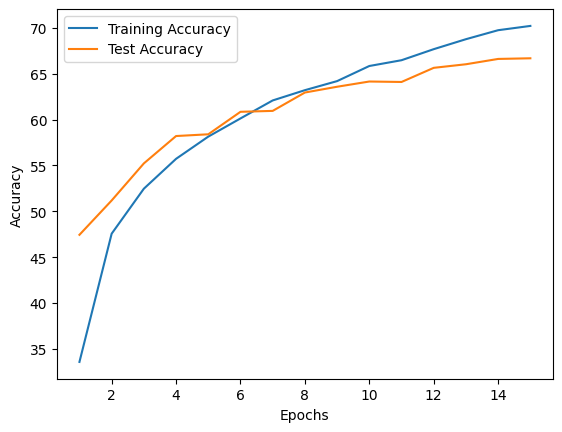

In [17]:
epochs = np.arange(1, num_epochs+1)
import matplotlib.pyplot as plt

plt.figure()
plt.plot(epochs, train_accs, label='Training Accuracy')
plt.plot(epochs, test_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

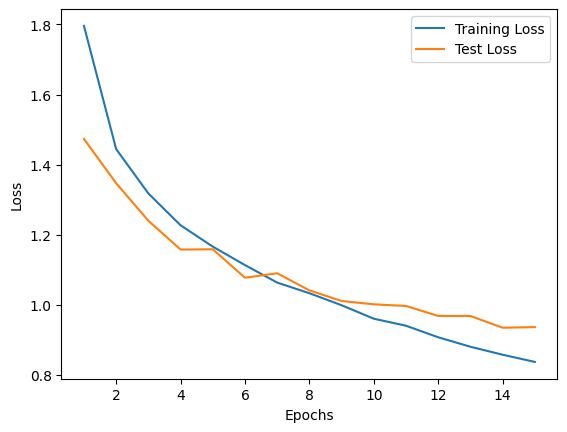

In [18]:
plt.figure()
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import os
if os.path.exists('/content/drive/MyDrive/vit') == False:
  os.mkdir('/content/drive/MyDrive/vit')

In [ ]:
torch.save(model.cpu().state_dict(), 'model_saved_71_acc_vit.pth')

In [19]:
model

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformerEncoderBlock): Sequential(
    (0): TransformerEncoderBlock(
      (MSABlock): MultiHeadSelfAttention(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (multi_head_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
      )
      (MLPBlock): MLPBlock(
        (layer): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=64, out_features=128, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.2, inplace=False)
          (3): Linear(in_features=128, out_features=64, bias=True)
          (4): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (1): Transfor

In [ ]:
del model, optimizer, criterion
import gc
gc.collect()
torch.cuda.empty_cache()